# Long Term Trends

## 1. Calculate STAR-PU denominators

In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT * 
FROM ebmdatalab.ONS.oral_antibiotics_star_pu'''
q2 = '''SELECT *
FROM ebmdatalab.ONS.england_population_1998_2016 
'''

m = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
pop = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False).drop(["location","all_ages"],axis=1)

# create age band groups
m = m.rename(columns={"Age_Band":"age_band"})
m["min_age"] = m["age_band"].str.split('-',expand=True)[0].str.replace("+","").astype(int)
m = m.sort_values(by="min_age")



In [2]:
m2 = pd.DataFrame(m[["age_band","item_male","item_female","cost_male","cost_female"]].set_index("age_band").unstack()).reset_index().sort_values(by="age_band")
section_code_current = '0501'
m2 = m2.rename(columns={"level_0":"category",0:"multiplier"})

m2["measure"] = m2["category"].str.split('_',expand=True)[0]
m2["gender"] = m2["category"].str.split('_',expand=True)[1]

m2 = m2.drop("category",axis=1)
m2 = m2.set_index(["age_band","gender","measure"]).unstack().reset_index(col_level=1)
m2.columns = m2.columns.droplevel()
m2

measure,age_band,gender,cost,item
0,0-4,female,2.8,0.8
1,0-4,male,3.2,0.8
2,15-24,female,2.5,0.6
3,15-24,male,2.1,0.3
4,25-34,female,2.0,0.6
5,25-34,male,1.1,0.2
6,35-44,female,2.1,0.6
7,35-44,male,1.0,0.3
8,45-54,female,2.3,0.6
9,45-54,male,1.4,0.3


In [3]:
p2 = pd.DataFrame(pop.set_index(["year","gender"]).stack()).reset_index()
p2["gender"] = p2.gender.str.lower()
p2 = p2.rename(columns={"level_2":"_age",0:"population"})
p2["age"] = p2["_age"].str.replace("_","").astype(int)

# Group into age bands
conditions = [
    (p2['age']<5 ),
    (p2['age']<15 ),
    (p2['age']<25 ),
    (p2['age']<35 ),
    (p2['age']<45 ),
    (p2['age']<55 ),
    (p2['age']<65 ),
    (p2['age']<75 ),
    (p2['age']>=75)]
choices = m["age_band"].drop_duplicates().values
p2['age_band'] = np.select(conditions, choices, default='75+')

p3 = pd.DataFrame(p2.groupby(["year","age_band","gender"])["population"].sum()).reset_index()
p3 = p3.merge(m2,on=["age_band","gender"])
p3["item_star-pu"] = p3.population*p3.item
p3["cost_star-pu"] = p3.population*p3.cost
starpu = pd.DataFrame(p3.groupby(["year"])["item_star-pu","cost_star-pu"].sum()).reset_index()
starpu.head()

,year,item_star-pu,cost_star-pu
0,1998,26914610.0,111491490.0
1,1999,27018730.0,111926740.0
2,2000,27127640.0,112364760.0
3,2001,27249436.5,112905819.5
4,2002,27392281.2,113551221.2


## 2. Import data

In [4]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q4 = '''SELECT 
  year,
  para_current,
  sum(items) as items, 
  sum(ItemsPer1000) as items_per_1000, 
  sum(quantity) AS quantity,
  sum(Infl_corr_Cost) as cost
FROM ebmdatalab.helen.trends_from_pca_final_2016 p
WHERE chapter_code_current = '05' AND section_code_current = '01'

GROUP BY 
  year,
  para_current'''

dfl = pd.io.gbq.read_gbq(q4, GBQ_PROJECT_ID, dialect='standard',verbose=True).fillna(0)
dfl.head()

Requesting query... ok.
Job ID: 02e9e38c-d7fc-4fe7-9b46-ab751ee3667f
Query running...
Query done.
Processed: 12.1 MB Billed: 13.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 247 rows.

Total time taken 3.82 s.
Finished at 2018-02-23 10:14:01.


,year,para_current,items,items_per_1000,quantity,cost
0,2012,Macrolides,5205786.0,97.315871,235306714.0,3.678457e+07
1,2016,Macrolides,4421982.0,80.009662,183693680.0,2.128058e+07
2,2002,Macrolides,4407141.0,88.711818,237094942.0,4.225814e+07
3,2015,Macrolides,4552746.0,83.100082,194291521.0,2.586846e+07
4,1998,Macrolides,5680000.0,116.344330,339588400.0,4.264914e+07


In [5]:
# Merge data with STAR-PU multipliers

l2 = dfl
l3 = l2.merge(starpu, on="year")
l3["items_per_starpu"] = l3["items"]/l3["item_star-pu"]
l3["cost_per_starpu"] = l3["cost"]/l3["cost_star-pu"]
l3["quantity_per_item"] = l3["quantity"]/l3["items"]

l3 = l3.drop(["item_star-pu","cost_star-pu","quantity"],axis=1)
l3 = pd.DataFrame(l3.set_index(["year","para_current"]).stack()).reset_index(col_level=1)
l3 = l3.rename(columns={"level_2":"measure",0:"value"})
l3 = pd.DataFrame(l3.set_index(["year","measure","para_current"]).unstack()).reset_index(col_level=1)
l3.columns = l3.columns.droplevel()
l3

para_current,year,measure,Aminoglycosides,Antileprotic Drugs,Antituberculosis Drugs,Cephalosporins and other Beta-Lactams,Clindamycin and Lincomycin,Macrolides,"Metronidazole, Tinidazole & Ornidazole",Penicillins,Quinolones,Some Other Antibacterials,Sulfonamides And Trimethoprim,Tetracyclines,Urinary-Tract Infections
0,1998,cost,1.213774e+06,7.439354e+04,2.301250e+06,2.979772e+07,8.917324e+05,4.264914e+07,2.237888e+06,8.002058e+07,2.921078e+07,4.974750e+06,3.383916e+06,3.147271e+07,1.907926e+06
1,1998,cost_per_starpu,1.088670e-02,6.672576e-04,2.064059e-02,2.672646e-01,7.998211e-03,3.825327e-01,2.007227e-02,7.177281e-01,2.620001e-01,4.461999e-02,3.035134e-02,2.822880e-01,1.711275e-02
2,1998,items,8.100000e+03,2.450000e+04,9.760000e+04,3.952400e+06,5.310000e+04,5.680000e+06,1.552600e+06,2.390510e+07,1.309300e+06,3.690000e+04,2.794900e+06,2.926100e+06,2.750000e+05
3,1998,items_per_1000,1.659136e-01,5.018373e-01,1.999156e+00,8.095763e+01,1.087656e+00,1.163443e+02,3.180215e+01,4.896519e+02,2.681860e+01,7.558285e-01,5.724837e+01,5.993576e+01,5.632868e+00
4,1998,items_per_starpu,3.009518e-04,9.102863e-04,3.626283e-03,1.468496e-01,1.972906e-03,2.110378e-01,5.768614e-02,8.881830e-01,4.864644e-02,1.371003e-03,1.038432e-01,1.087179e-01,1.021750e-02
5,1998,quantity_per_item,5.251852e+01,5.993878e+01,9.249590e+01,4.027834e+01,2.837288e+01,5.978669e+01,2.066250e+01,4.760665e+01,1.632758e+01,7.229810e+01,3.075530e+01,5.960726e+01,3.166291e+01
6,1999,cost,1.081163e+06,1.159237e+05,2.660100e+06,2.434342e+07,8.993166e+05,4.481667e+07,5.198690e+06,9.761168e+07,2.644597e+07,5.234584e+06,3.828695e+06,3.288141e+07,1.893886e+06
7,1999,cost_per_starpu,9.659562e-03,1.035711e-03,2.376644e-02,2.174942e-01,8.034869e-03,4.004107e-01,4.644726e-02,8.721033e-01,2.362793e-01,4.676795e-02,3.420715e-02,2.937762e-01,1.692077e-02
8,1999,items,7.600000e+03,2.500000e+04,1.004000e+05,3.320800e+06,5.610000e+04,4.965900e+06,1.548100e+06,2.165540e+07,1.176900e+06,3.950000e+04,2.775300e+06,2.698400e+06,2.678000e+05
9,1999,items_per_1000,1.549980e-01,5.098617e-01,2.047605e+00,6.772596e+01,1.144130e+00,1.012769e+02,3.157268e+01,4.416504e+02,2.400225e+01,8.055816e-01,5.660077e+01,5.503244e+01,5.461639e+00


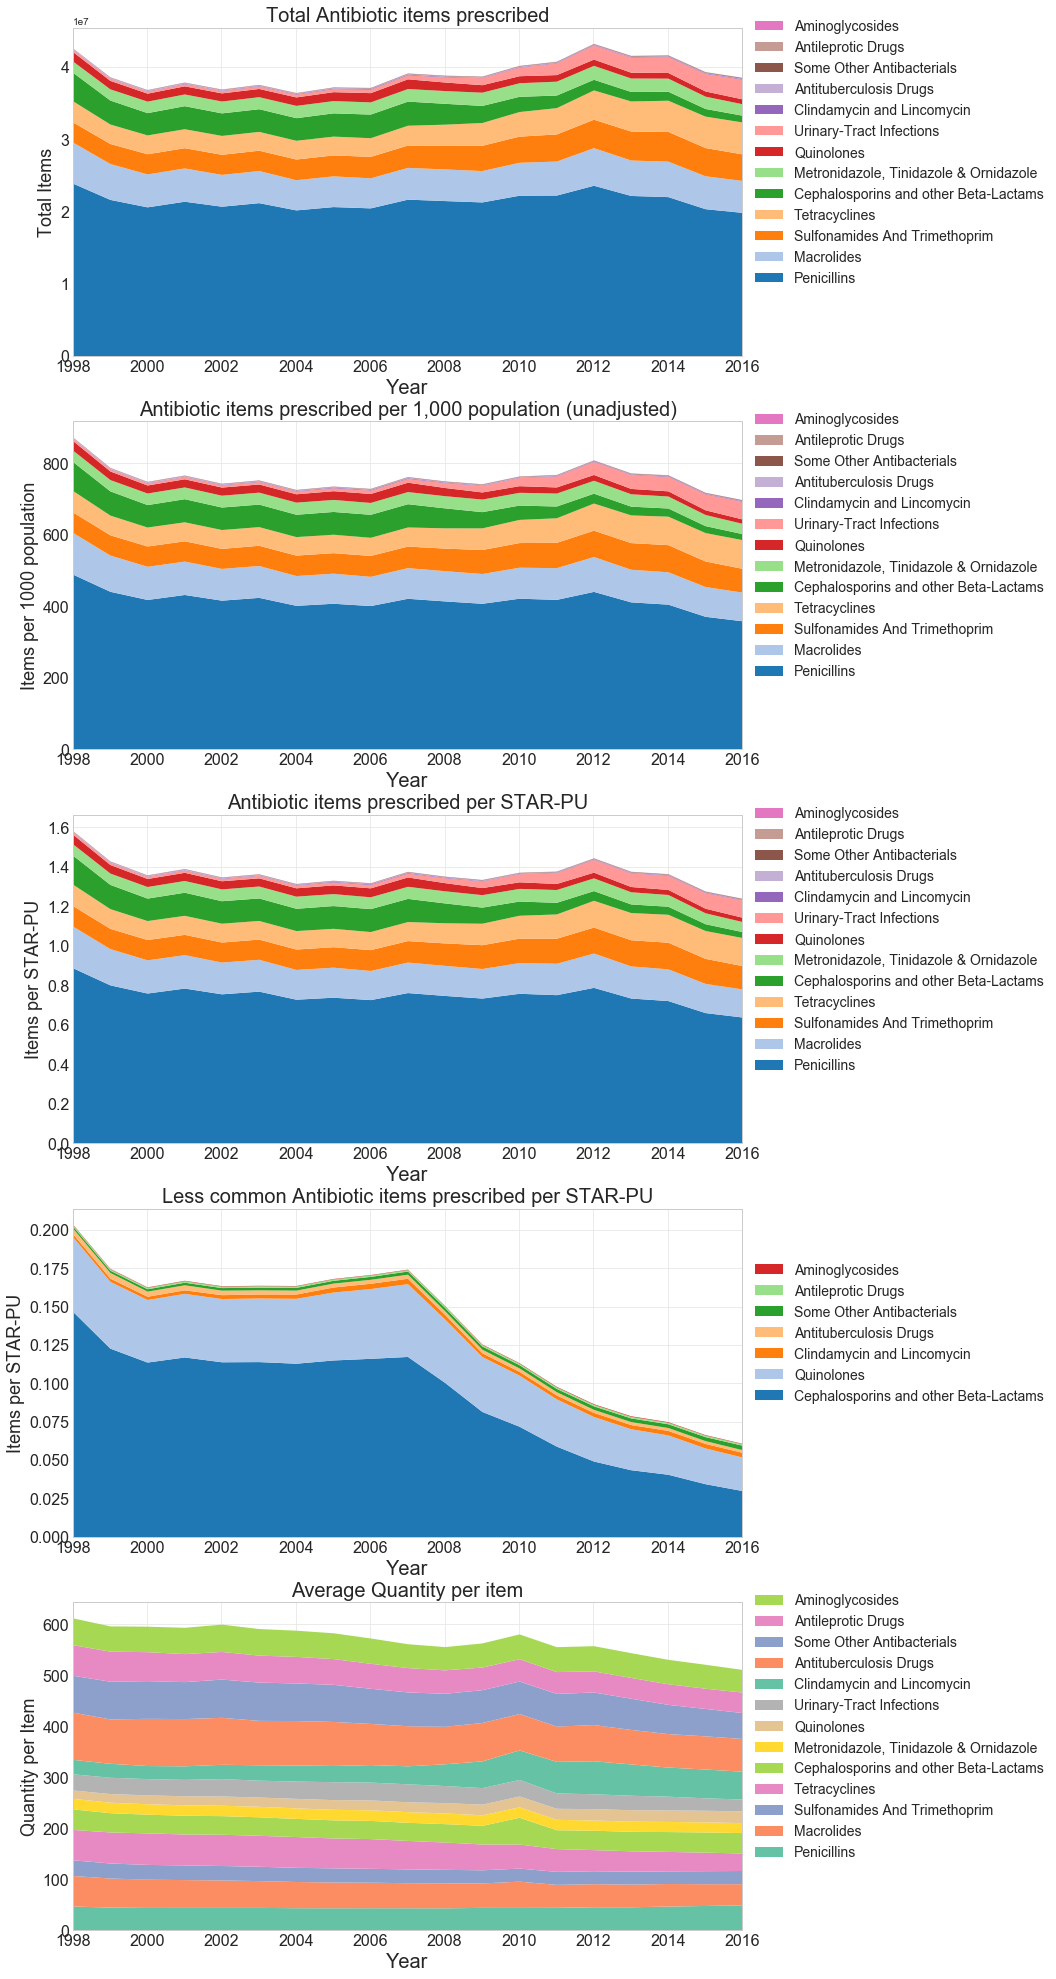

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})
sns.set_palette("tab20",n_colors=14)

dfp = l3

dft = l3.drop("year",axis=1).groupby("measure").sum(axis=1).transpose().sort_values(by="items",ascending=False).reset_index()
sort_order = pd.Series(dft.para_current)
sort_order.loc[13] = "year"

dft = l3[["measure","Aminoglycosides","Antileprotic Drugs","Antituberculosis Drugs","Cephalosporins and other Beta-Lactams","Clindamycin and Lincomycin","Quinolones","Some Other Antibacterials"]].groupby("measure").sum(axis=1).transpose().sort_values(by="items",ascending=False).reset_index()
sort_order2 = pd.Series(dft.para_current)
sort_order2.loc[7] = "year"        

s = [(0,"items","Total Items", "Total Antibiotic items prescribed"),
     (1,"items_per_1000","Items per 1000 population", "Antibiotic items prescribed per 1,000 population (unadjusted)"),
     (2,"items_per_starpu","Items per STAR-PU", "Antibiotic items prescribed per STAR-PU"),
     (3,"items_per_starpu","Items per STAR-PU", "Less common Antibiotic items prescribed per STAR-PU"),
     #(4,"cost_per_starpu","Cost (2016 equivalent £) per STAR-PU", "Antibiotic costs per STAR-PU")
     (4,"quantity_per_item","Quantity per Item","Average Quantity per item")
]

fig = plt.figure(figsize=(15,35))
   
for i in s:
    ax = plt.subplot(5,1,i[0]+1)  # layout and position of subplot
    if i[0] == 3: 
        dfp = l3[["year","measure","Aminoglycosides","Antileprotic Drugs","Antituberculosis Drugs","Cephalosporins and other Beta-Lactams","Clindamycin and Lincomycin","Quinolones","Some Other Antibacterials"]]
        dfp = dfp.loc[dfp["measure"] == i[1]].drop("measure",axis=1)
        dfp = dfp.reindex(columns=sort_order2)
        sns.set_palette("Set2",n_colors=14)
    else:    
        dfp = l3.loc[l3["measure"] == i[1]].drop("measure",axis=1)
        dfp = dfp.reindex(columns=sort_order)
    dfp.plot(ax=ax, x="year", kind='area',  linewidth=0)
    #dfp.plot(ax=ax, kind='area',  linewidth=0)
    ax.set_xlabel('Year', fontsize="20")
    ax.set_ylabel(i[2], size="18")
    ax.set_title(i[3], size="20")
    ax.tick_params(labelsize=16)
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1, .62), fontsize='14')
    
#fig.legend( loc = (0.5, 0), ncol=5 )
#plt.setp(ax.get_legend().get_title(), fontsize='40') # for legend title
plt.show()
#dfp
